In [2]:
import os
os.getcwd()
import sys 
sys.path.append('/data/users/miroojin/saksham/watermark-adapters')

In [3]:
import json
from src.utils import MbMark, MbClusterDetector, GaussMark
from sklearn.metrics import roc_auc_score
import os
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from datasets import load_dataset, load_from_disk
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats
torch.manual_seed(42)
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.interpolate import interp1d

In [ ]:
model_name = "meta-llama/Llama-2-7b-hf"
model_suffix = model_name.split("/")[-1]
output_file = os.getenv("OUTPUT_FILE", "../output/test/output_delta1.5_gamma0.4.json")

assert output_file is not None, "Please set the OUTPUT_FILE environment variable to the path of your output file."


BATCH_SIZE = 64
print(f"Batch size: {BATCH_SIZE}")
print(f"Model name: {model_name}")


Batch size: 64
Model name: meta-llama/Llama-2-7b-hf
Final matrix path: ../output/test/final_matrix.pt


In [5]:
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    device_map="auto")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


In [6]:

with open(output_file, "r") as f:
    output_data = json.load(f)

def filter_length(example):
    return len(tokenizer(example["text"])['input_ids']) >= 400

In [7]:
dataset_name = "Skylion007/openwebtext"
dataset_suffix = dataset_name.split("/")[-1]
dataset = load_dataset(dataset_name,
                       split="train", streaming=True, trust_remote_code=True)

dataset = dataset.filter(filter_length)

dataset = dataset.shuffle(seed=42).take(5000)

# Truncate each sample to random lengths between 150 and 400


def truncate(example):
    input_ids = tokenizer(example["text"])['input_ids']
    length = np.random.randint(150, 400)
    truncated_input_ids = input_ids[:length]
    example["text"] = tokenizer.decode(
        truncated_input_ids, skip_special_tokens=True)
    return example


dataset = dataset.map(truncate)
# Get text column as list
texts = [example["text"] for example in dataset]

In [ ]:

model = AutoModelForCausalLM.from_pretrained(
    model_name, device_map="auto", torch_dtype=torch.bfloat16)

watermark_type = output_data["watermark"]
config = output_data["config"]


final_weight = torch.tensor(output_data["final_matrix"])

watermark = MbMark(
    delta=config["delta"],
    gamma=config["gamma"],
    seed=config["hash_key"],
    final_weight=final_weight,
    model=model,
    tokenizer=tokenizer,
    unembedding_param_name=config["unembedding_param_name"]
)   

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/tmp/ipykernel_643041/35316802.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_weight = torch.load(final_matrix_path).cpu()


In [ ]:
# Iterate through the dataset in batches


def get_llrs(data):
    all_likelihood_ratios = []

    for i in range(0, len(data), BATCH_SIZE):
        batch = data[i:i + BATCH_SIZE]
        with torch.no_grad():
            likehood_ratios = watermark.lrt(batch)
        all_likelihood_ratios.append(likehood_ratios)

    all_likelihood_ratios = torch.cat(all_likelihood_ratios)
    return all_likelihood_ratios

null_likehood_ratios = get_llrs(texts)


Processing batch 1/79
Processing batch 2/79
Processing batch 3/79
Processing batch 4/79
Processing batch 5/79
Processing batch 6/79
Processing batch 7/79
Processing batch 8/79
Processing batch 9/79
Processing batch 10/79
Processing batch 11/79
Processing batch 12/79
Processing batch 13/79
Processing batch 14/79
Processing batch 15/79
Processing batch 16/79
Processing batch 17/79
Processing batch 18/79
Processing batch 19/79
Processing batch 20/79
Processing batch 21/79
Processing batch 22/79
Processing batch 23/79
Processing batch 24/79
Processing batch 25/79
Processing batch 26/79
Processing batch 27/79
Processing batch 28/79
Processing batch 29/79
Processing batch 30/79
Processing batch 31/79
Processing batch 32/79
Processing batch 33/79
Processing batch 34/79
Processing batch 35/79
Processing batch 36/79
Processing batch 37/79
Processing batch 38/79
Processing batch 39/79
Processing batch 40/79
Processing batch 41/79
Processing batch 42/79
Processing batch 43/79
Processing batch 44/

#### Human text / negative sample scores

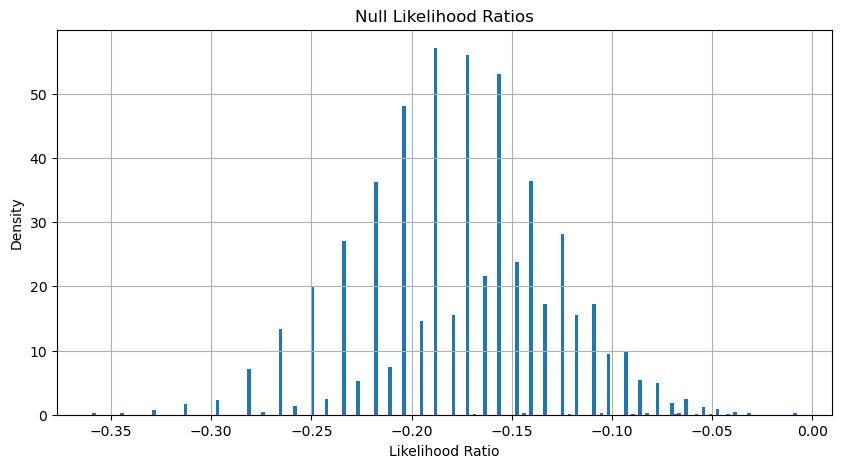

In [10]:


# Plot the histogram of the null likelihood ratios
plt.figure(figsize=(10, 5))
plt.hist(null_likehood_ratios, bins=200, density=True)
plt.title("Null Likelihood Ratios")
plt.xlabel("Likelihood Ratio")
plt.ylabel("Density")
plt.grid()
plt.show()


In [11]:
base_llr_statistics = {
    "mean": null_likehood_ratios.mean().item(),
    "std": null_likehood_ratios.std().item(),
}

output_data["base_llr_statistics"] = base_llr_statistics

# Save the updated output data
with open(output_file, "w") as f:
    json.dump(output_data, f, indent=4)